In [1]:
from torch_snippets import *
from torchvision import datasets
data_folder = '/home/yyr/data/FMNIST/' # This can be any directory you want to download FMNIST to


In [2]:
tr_fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
N = 10000
tr_images = tr_fmnist.data[:N]
tr_targets = tr_fmnist.targets[:N]

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data[:N]
val_targets = val_fmnist.targets[:N]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([
              iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),
            ])
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x.cpu().numpy(), y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        # if self.aug: x = self.aug.augment_image(x)
        return x, y
    def __len__(self): return len(self.x)
    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        if self.aug: ims = self.aug(images=ims) # transform a batch of images at once
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)     
    trn_dl = DataLoader(train, batch_size=2048, collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images)//5, collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [5]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [6]:
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    train_epoch_losses, train_epoch_accuracies = [], []
    N = len(trn_dl)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        pos = (epoch + (ix+1)/N)
        log.record(pos=pos, train_loss=batch_loss, end='\r') # impersistent data    

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        pos = (epoch + (ix+1)/N)
        log.record(pos=pos, train_acc=np.mean(is_correct), end='\r') # impersistent data

    N = len(val_dl)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        pos = (epoch + (ix+1)/N)
        log.record(pos=pos, val_loss=batch_loss, val_acc=np.mean(val_is_correct), end='\r') # impersistent data
    log.report_avgs(epoch+1) # persist

EPOCH: 1.000	train_loss: 2.202	train_acc: 0.378	val_loss: 1.910	val_acc: 0.426	(7.30s - 29.21s remaining)
EPOCH: 2.000	train_loss: 1.665	train_acc: 0.470	val_loss: 1.565	val_acc: 0.536	(14.56s - 21.84s remaining)
EPOCH: 3.000	train_loss: 1.384	train_acc: 0.544	val_loss: 1.326	val_acc: 0.581	(21.83s - 14.55s remaining)
EPOCH: 4.000	train_loss: 1.210	train_acc: 0.602	val_loss: 1.222	val_acc: 0.624	(29.02s - 7.26s remaining)
EPOCH: 5.000	train_loss: 1.115	train_acc: 0.635	val_loss: 1.087	val_acc: 0.656	(36.30s - 0.00s remaining)


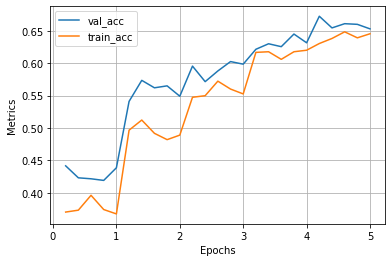

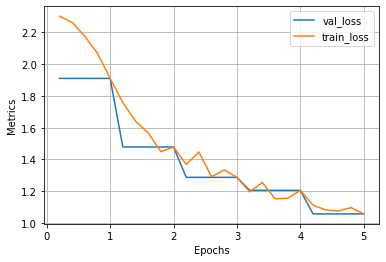

In [7]:
log.plot(['val_acc','train_acc'])
log.plot(['val_loss','train_loss'])